In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import networkx as nx
import random

import pdfplumber

from PIL import Image
from wordcloud import WordCloud
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from itertools import combinations
from collections import Counter
import re

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords, brown
from nltk.stem.wordnet import WordNetLemmatizer
import spacy

from textblob import TextBlob

from tqdm import trange
import requests
from bs4 import BeautifulSoup

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
eng_stopwords = stopwords.words("english")
Tokenizer = RegexpTokenizer(r"[A-Za-z0-9-]+")
wl=WordNetLemmatizer()
nlp = spacy.load('en_core_web_lg')
analyser = SentimentIntensityAnalyzer()
colors = ['tomato', 'khaki', 'plum', 'lightskyblue','palegreen']

## Preparing data (pages and chapters)

In [4]:
def prepare_pages(name):
    """
    converts pdf file to list of strings
    
    Input:
        name: str - name of book in PDF format
        
    Output:
        pages: list - list of pages in book
    """
    
    pages = []
    with pdfplumber.open(name) as pdf:
        for i in trange(12, 273):
            pages.append(pdf.pages[i].extract_text())
            
    return pages

In [5]:
def prepare_chapters(pages):
    """
    creates list of chapters, every chapter is equivalent to every letter in alphabet
    
    Input:
        pages: list - list of pages in book
    
    Output:
        chapters: list - list of chapters in book  
    """
    letter = 'A' # chapter in this book are marked as letters
    chapter = ''
    chapters = []
    for page in pages:
        if page[:6].replace('\n', '').replace(' ', '') == letter: # finding beggining of every chapters
            chapters.append(chapter)
            chapter = ''
            letter = chr(ord(letter) + 1)     
        else:
            chapter += page

        if page == pages[-1]:
            chapters.append(chapter)

    chapters = chapters[1:]
    
    return chapters

## Preparation of global variables 

In [6]:
pages = prepare_pages('KG.pdf')
chapters = prepare_chapters(pages)
pages = [page.replace('\n', '') for page in pages]
chapters = [chapter.replace('\n', '') for chapter in chapters]
all_text = ' '.join(pages)
all_sentences = nltk.tokenize.sent_tokenize(all_text)

100%|████████████████████████████████████████████████████████████████████████████████| 261/261 [00:59<00:00,  4.37it/s]


In [7]:
f'Number of chapters (one for each letter): {len(chapters)}, number of pages: {len(pages)}, number of sentences: {len(all_sentences)}'

'Number of chapters (one for each letter): 26, number of pages: 261, number of sentences: 8218'

## Number of characters

In [8]:
def find_number_of_characters(text):
    """
    finds number of characters in text
    
    Input:
        text: str - text in which number of every characters will be found
        
    Output:
        counter: dict - dictionary with number of occurre
    """
    counter = dict(Counter(re.sub('[^a-z]', '', text.lower())))
    counter = dict(sorted(counter.items(), key=lambda item: item[0]))
    
    return counter

In [9]:
counter = find_number_of_characters(all_text)

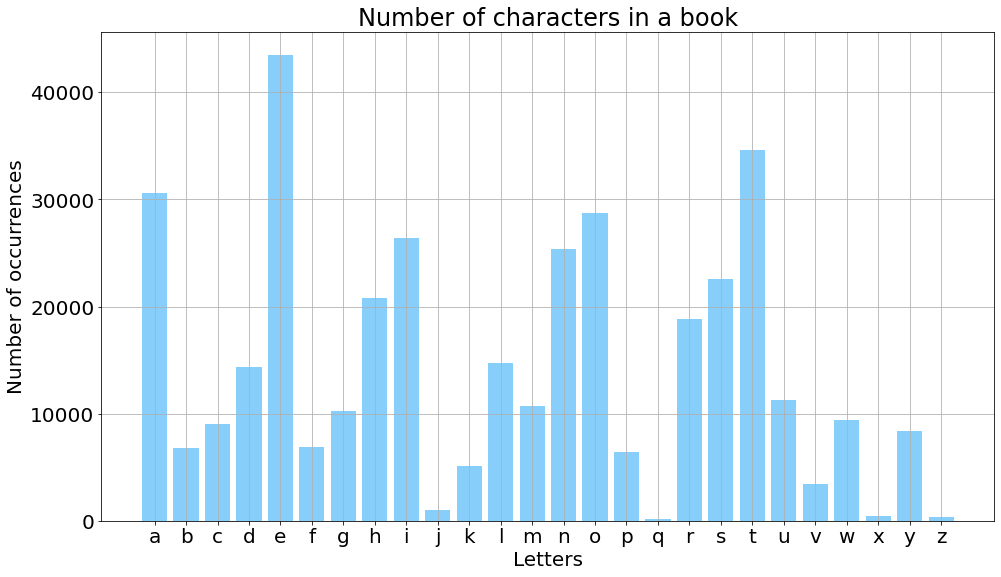

In [10]:
plt.rc("xtick", labelsize=20)
plt.rc("ytick", labelsize=20)
plt.figure(figsize=(16, 9))
plt.bar(range(len(counter)), list(counter.values()), align='center', color=colors[3])
plt.xticks(range(len(counter)), list(counter.keys()))
plt.title('Number of characters in a book', fontsize=24)
plt.ylabel('Number of occurrences', fontsize=20)
plt.xlabel('Letters', fontsize=20)
plt.grid()

From the graph above we can see that the most common letter in this book is 'e'. It confirms that this letter is the most popular letter in the English language. The next two letters are: 't' and 'a', which seem like good results. This autobiography is about Kevin Garnett, so one can think that 'k' and 'g' should be common as well, however, the main character describes his story in the first person.

## Number of words per one page

In [11]:
number_of_words = []
for i in range(len(pages)):
    words = pages[i].split(' ')
    words = [word for word in words if word != '']
    number_of_words.append(len(words))

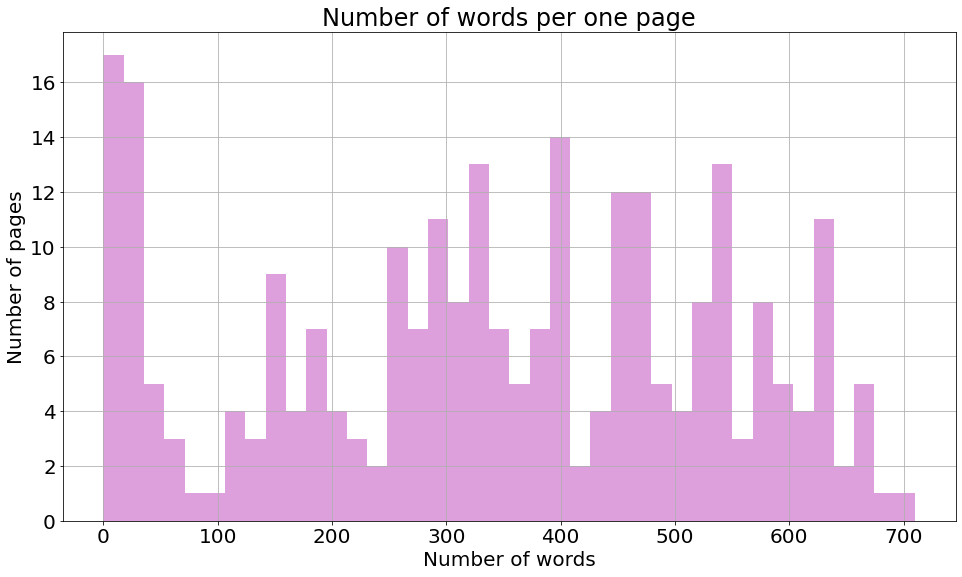

In [12]:
plt.figure(figsize=(16, 9))
plt.hist(number_of_words, bins=40, color=colors[2])
plt.title('Number of words per one page', fontsize=24)
plt.ylabel('Number of pages', fontsize=20)
plt.xlabel('Number of words', fontsize=20)
plt.grid()

The distribution of the number of words on every page is irregular. It is caused by some photos, which can occupy sometimes all pages or a part of a single page. Moreover, pages, which introduce a new chapter are significantly shorter than the regular one. In this book, there are a lot of dialogues, which lessens the number of words per one page

## Number of sentences per one page

In [13]:
number_of_sentences = []
for i in range(len(pages)):
    sentences = pages[i].replace(' ', '').split('.')
    sentences = [sentence for sentence in sentences if sentence != '']
    if len(sentences) > 1:      
        number_of_sentences.append(len(sentences))

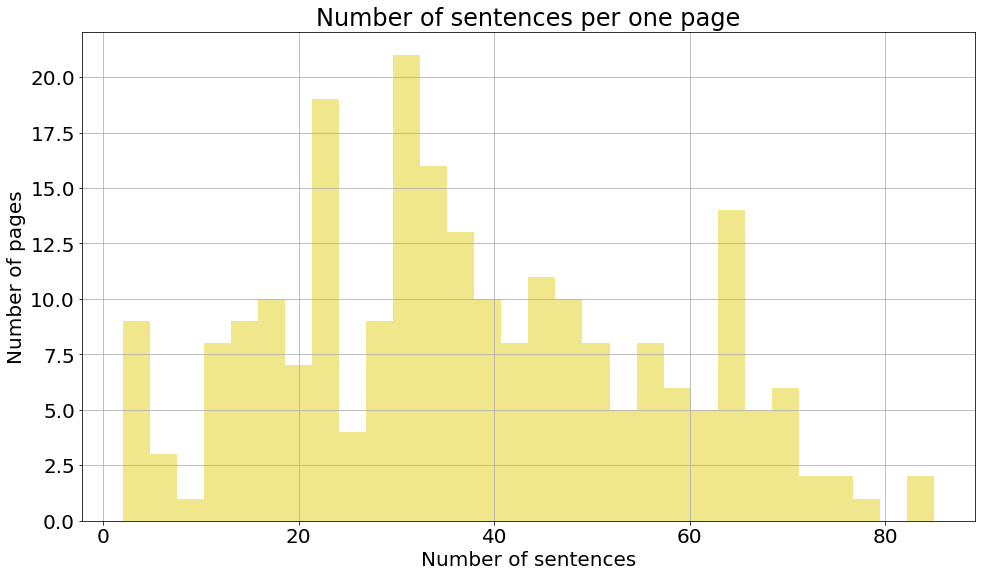

In [14]:
plt.figure(figsize=(16, 9))
plt.hist(number_of_sentences, bins=30, color=colors[1])
plt.title('Number of sentences per one page', fontsize=24)
plt.ylabel('Number of pages', fontsize=20)
plt.xlabel('Number of sentences', fontsize=20)
plt.grid()

The number of sentences on every page is irregular. It is caused by some photos, which can occupy sometimes all pages or a part of a single page. Moreover, pages, which introduce a new chapter are significantly shorter than the regular one. In this book, there are a lot of dialogues, which lessens the number of words per one page

## The most common words used in the book

In [15]:
def finding_words(all_text):
    words = all_text.split(' ')
    words = [word for word in words if word != '']
    cleaned_words = []
    for word in words:
        word = word.lower()
        word = Tokenizer.tokenize(word)  
        if len(word) > 0:
            word = [wl.lemmatize(word[0], 'v')]
            word = word if word[0] not in eng_stopwords else ['']
            word = word if len(word[0])>2 else ['']
            
            cleaned_words.append(word[0])

    cleaned_words = [word for word in cleaned_words if word != ['']]
    cleaned_words = [word for word in cleaned_words if word != '']
    
    return cleaned_words

In [16]:
def find_the_most_common_words(comments, limit=15):
    x = Counter(comments).most_common()[:limit]
    words = list(zip(*x))[0]
    occurrences = list(zip(*x))[1]
    
    return words, occurrences

In [17]:
cleaned_words = finding_words(all_text)

In [18]:
common_words, occurrences = find_the_most_common_words(cleaned_words, limit=15)

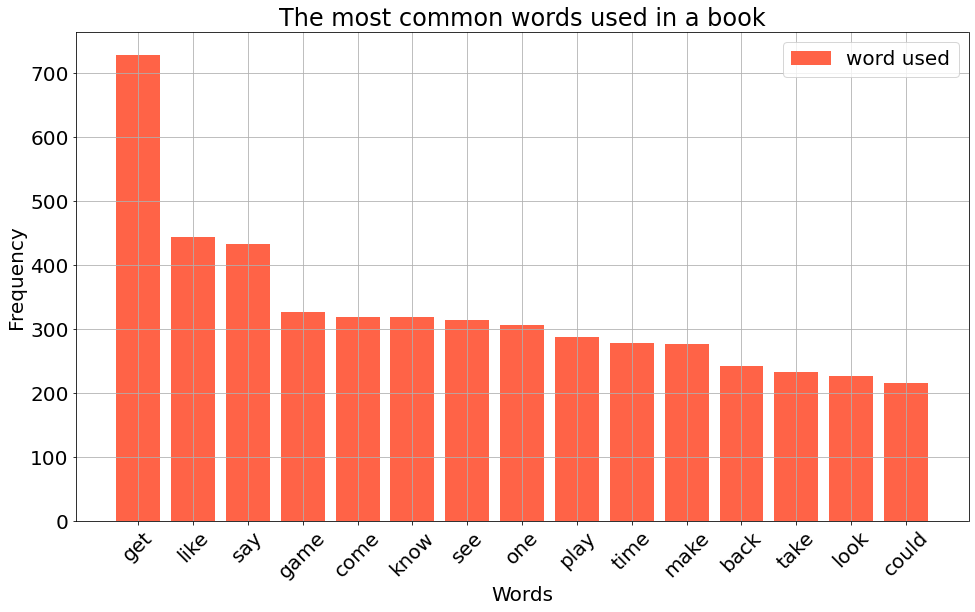

In [19]:
plt.figure(figsize=(16, 9))
plt.title('The most common words used in a book', fontsize=24)
plt.xlabel('Words', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.bar(common_words, occurrences, color=colors[0])
plt.legend(['word used'], prop={'size': 20})
plt.xticks(rotation=45)
plt.grid()

The most common words used in this book are rather casual informal words. This book is a kind of biography, which a basketball player wrote using his own words. He didn't use sophisticated sentences, a lot of dialogues are just simple states from the court.

## How often do the most common words appear in a single chapter?

In [20]:
top_five = list(common_words[:5])

In [21]:
top_five

['get', 'like', 'say', 'game', 'come']

In [22]:
counters_for_words = []
for word in top_five:
    counters = []
    for chapter in chapters:
        counters.append(finding_words(chapter).count(word))
        
    counters_for_words.append(counters)

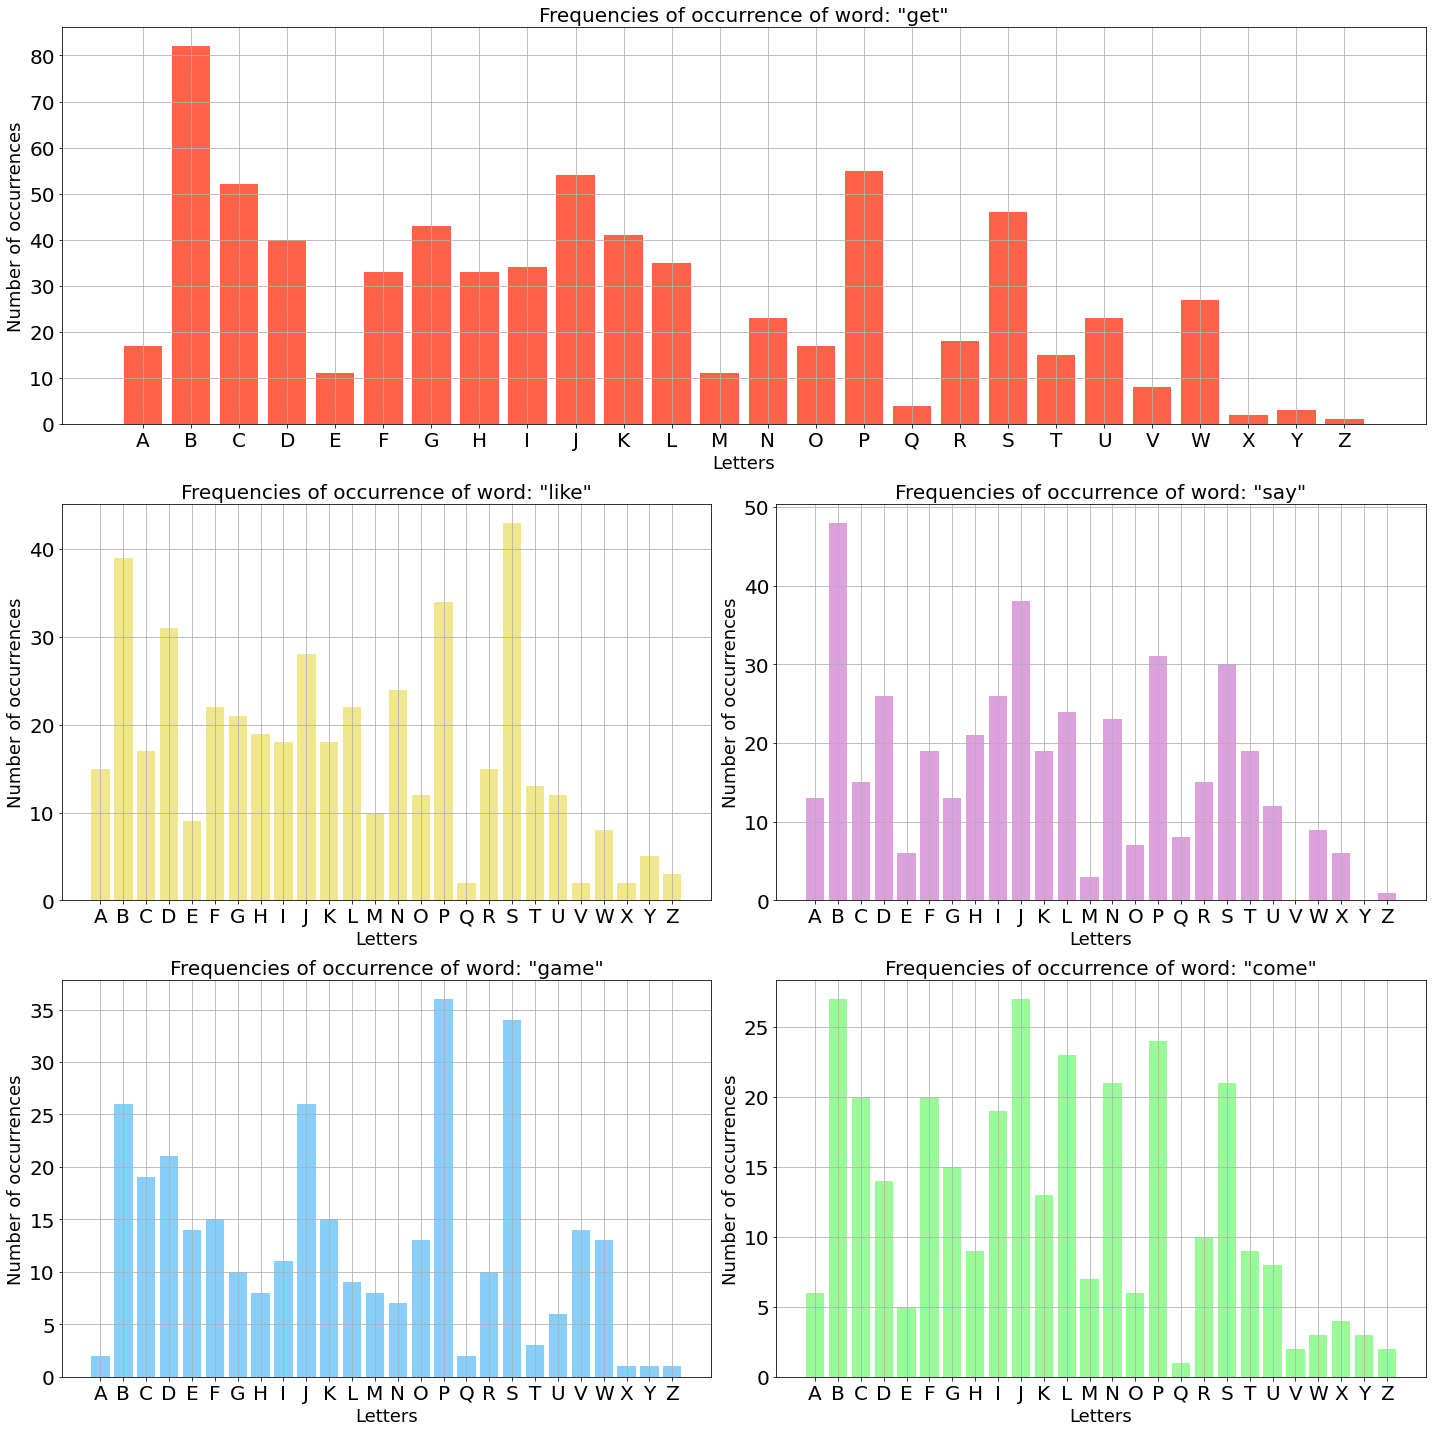

In [23]:
plt.figure(figsize=(20, 20))
for i, name in enumerate((top_five)):
    if i == 0:
        plt.subplot(3, 1, i+1)
    else:
        plt.subplot(3, 2, i+2)
    plt.title(f'Frequencies of occurrence of word: "{name}"', fontsize=20)
    plt.xlabel('Letters', fontsize=18)
    plt.ylabel('Number of occurrences', fontsize=18)
    plt.bar([chr(j) for j in range(65, 91)], counters_for_words[i], color=colors[i])
    plt.grid()
    
plt.tight_layout()

From above graphs, we can see clear dependence between a number of occurrences of the 5 most common words. For example: If the word "get" is common in a chapter "B", all different words have similar properties. It can also depend on the number of words inside one chapter, in the longer chapter, there is a higher possibility of occurrence of specific words.

## Top words in each category of part of the speech

Spacy POS description: https://machinelearningknowledge.ai/tutorial-on-spacy-part-of-speech-pos-tagging/

In [24]:
POS = ['VERB', 'PRON', 'DET', 'NOUN', 'ADP', 'ADJ', 'PUNCT', 'ADV', 'NUM']
for item in POS:
    print(f"{item}: {spacy.explain(item)}")

VERB: verb
PRON: pronoun
DET: determiner
NOUN: noun
ADP: adposition
ADJ: adjective
PUNCT: punctuation
ADV: adverb
NUM: numeral


In [25]:
def find_pos_tag(all_sentences):
    """
    finds part of speech of every element in a single sentence
    
    Input:
        all_sentences: list - list of sentences
        
    Output:
        spacy_pos_tagged: list - list of tuples with word and part of speech of this word
    """
    spacy_pos_tagged = []
    for sentence in all_sentences:
        spacy_pos_tagged.extend([(word, word.pos_) for word in nlp(sentence)])
        
    return spacy_pos_tagged

In [26]:
def get_pos_tag(words, tag, limit):
    """
    finds the most common part of speech tag from list of words
    
    Input:
        words: list - list of words
        tag: str - name of part of speech
        limit: int - number of returned the most common words
        
    Output:
        most_common: list - list of tuples with number of occurrences of specific words
    """
    pos_tag_words = []
    for word_tag in words:
        if word_tag[1] == tag:
            if word_tag[1] == 'VERB':            
                word = wl.lemmatize(str(word_tag[0]), 'v')          
            else:
                word = word_tag[0]
            if str(word) != '’s' and str(word) != '’m' and str(word) != '’d':
                pos_tag_words.append(str(word).lower())
    
    most_common = Counter(pos_tag_words).most_common()[:limit]
                 
    return most_common

In [27]:
spacy_pos_tagged = find_pos_tag(all_sentences)

In [28]:
for item in POS:
    print(item, get_pos_tag(spacy_pos_tagged, item, 15), '\n')

VERB [('get', 705), ('have', 546), ('go', 438), ('say', 429), ('do', 357), ('come', 319), ('know', 314), ('see', 313), ('make', 263), ('play', 259), ('take', 219), ('look', 202), ('want', 178), ('give', 158), ('think', 145)] 

PRON [('i', 3091), ('you', 1123), ('it', 1069), ('he', 1034), ('my', 934), ('me', 870), ('that', 637), ('we', 533), ('his', 506), ('they', 393), ('him', 308), ('who', 290), ('what', 269), ('your', 254), ('us', 177)] 

DET [('the', 4252), ('a', 1890), ('that', 339), ('all', 205), ('no', 195), ('an', 172), ('this', 170), ('some', 139), ('those', 128), ('every', 94), ('another', 68), ('these', 65), ('any', 44), ('each', 33), ('both', 11)] 

NOUN [('time', 256), ('game', 228), ('way', 160), ('shit', 137), ('life', 121), ('team', 117), ('man', 106), ('league', 102), ('brothas', 98), ('years', 96), ('thing', 92), ('players', 90), ('people', 85), ('year', 84), ('world', 84)] 

ADP [('in', 1377), ('of', 1347), ('to', 945), ('on', 635), ('with', 613), ('for', 548), ('up',

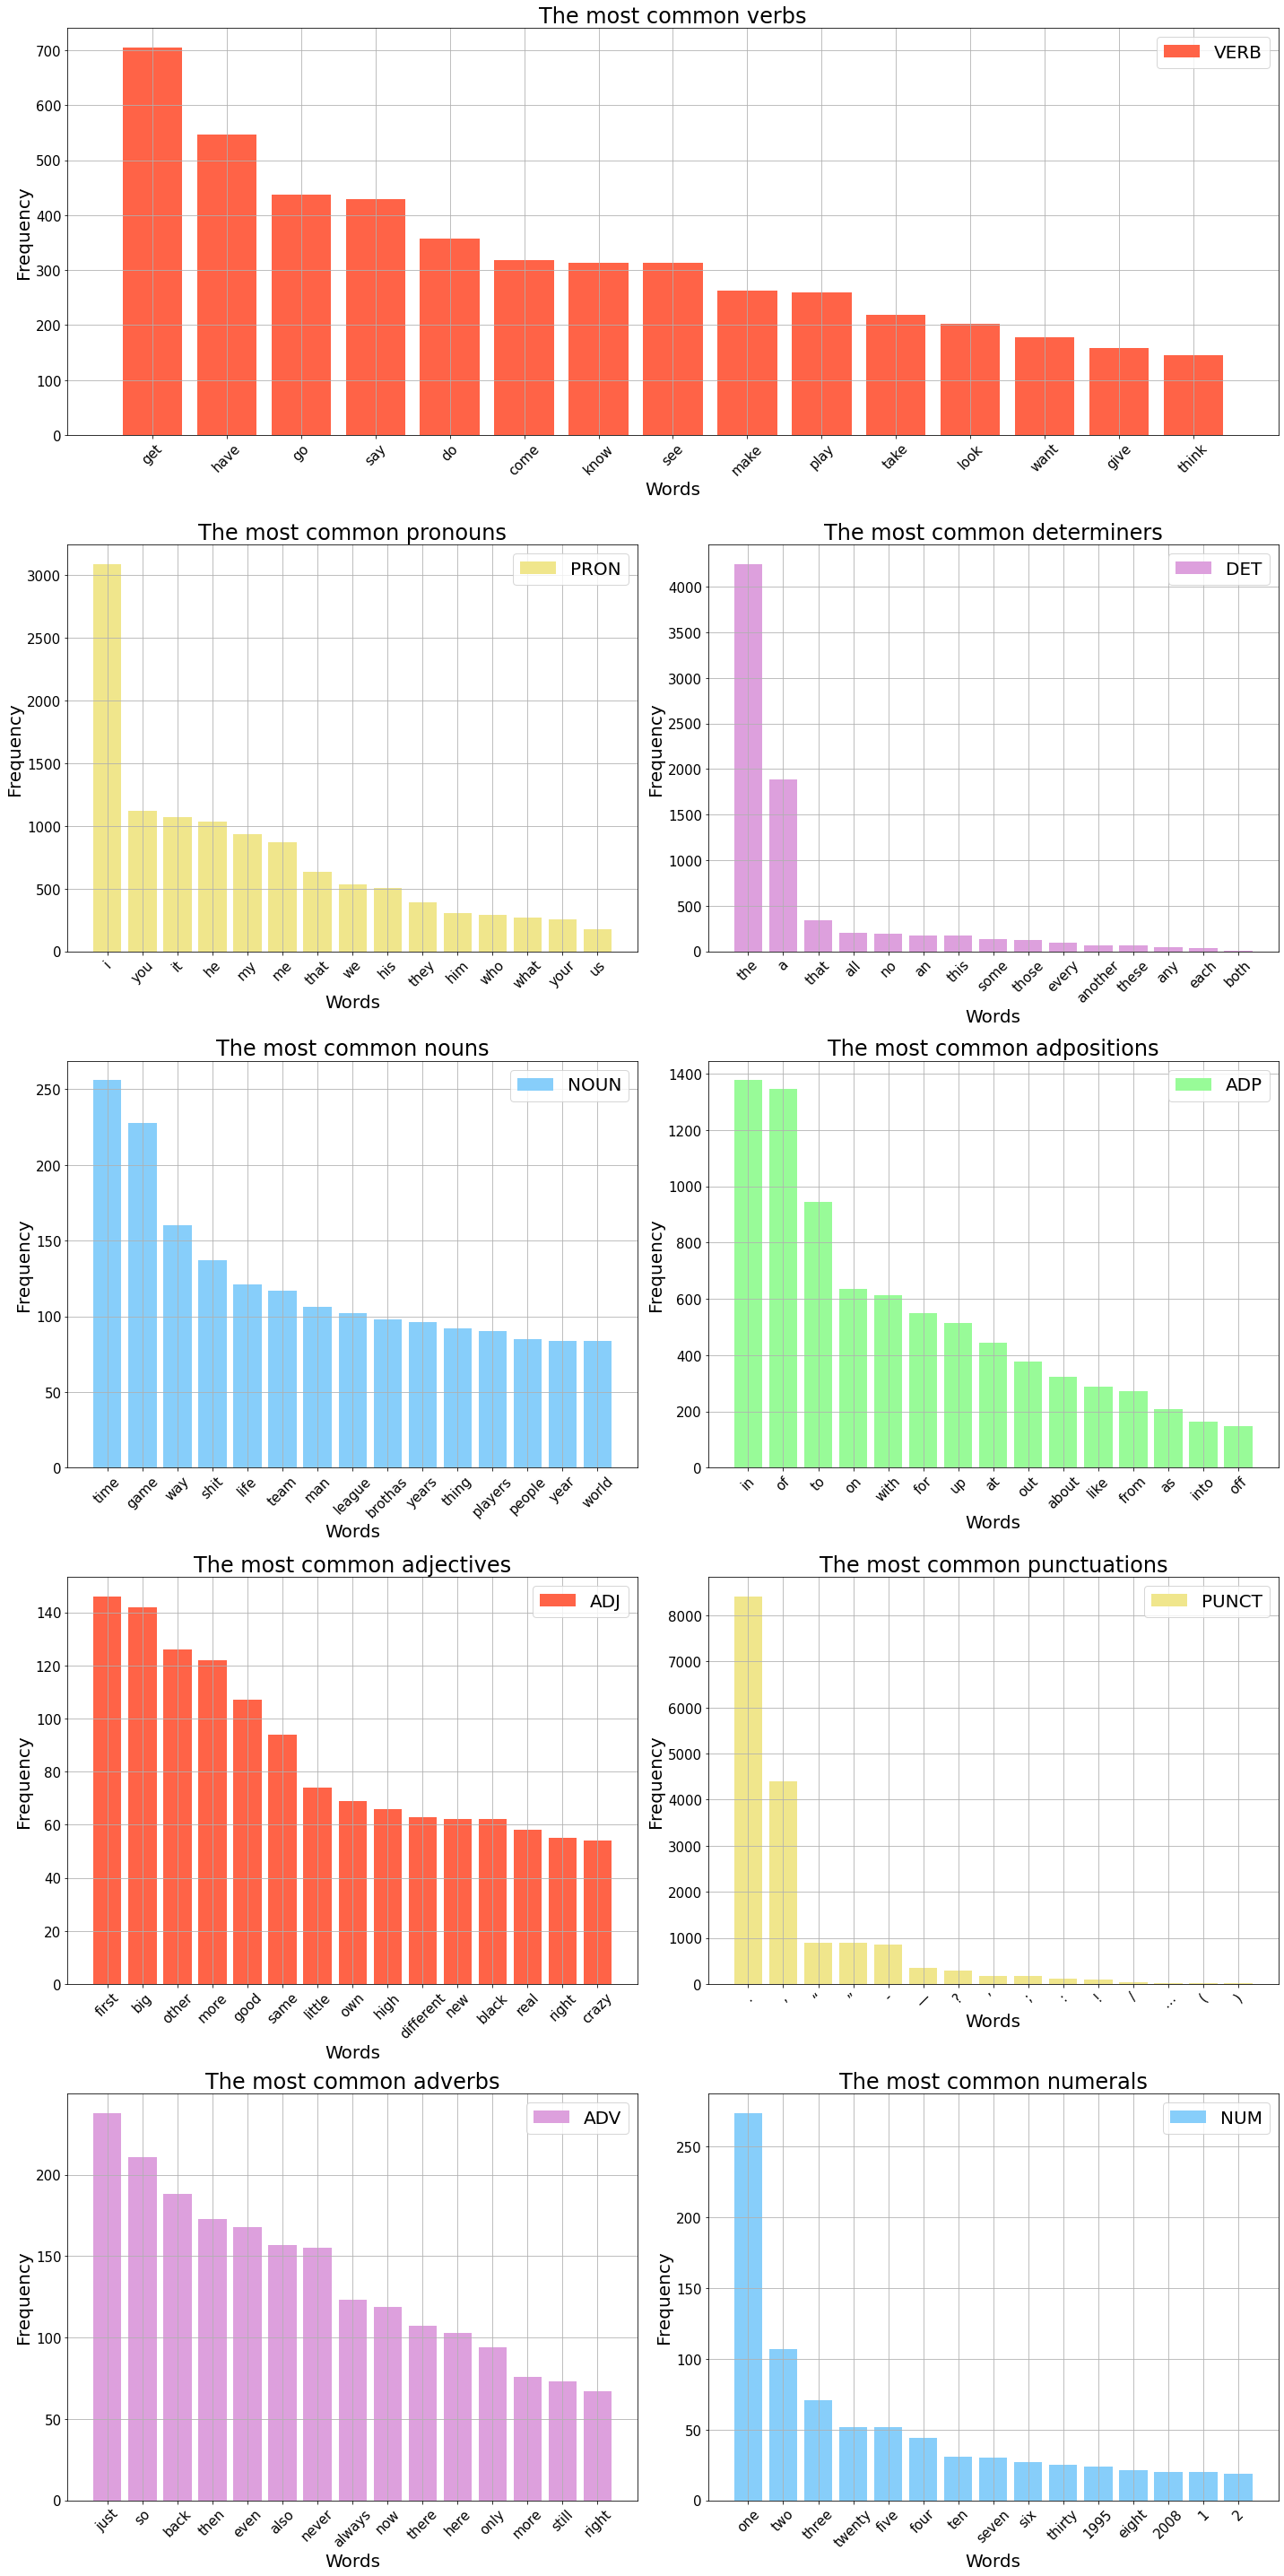

In [29]:
plt.figure(figsize=(20, 40))
plt.rc("ytick", labelsize=15)
plt.rc("xtick", labelsize=15)
for i, item in enumerate(POS):
    most_common = get_pos_tag(spacy_pos_tagged, item, 15)
    words = list(zip(*most_common))[0]
    occurrences = list(zip(*most_common))[1]
        
    if i == 0:
        plt.subplot(5, 1, i+1)
        plt.bar(words, occurrences, color=colors[i%len(colors)])
    else:
        plt.subplot(5, 2, i+2)
        plt.bar(words, occurrences, color=colors[i%len(colors)])

    plt.title(f"The most common {spacy.explain(item)}s", fontsize=24)
    plt.xlabel('Words', fontsize=20)
    plt.ylabel('Frequency', fontsize=20)
    plt.legend([item], prop={'size': 20})
    plt.xticks(rotation=45)
    plt.grid()
plt.tight_layout()

The most common verbs are rather informal and standard, which basketball players can use in their everyday life or on the court, e.g. get, have, go. Word strictly connected with basketball, which is "play" is on the 10th place, so it's a bit far from the top.

Pronouns are expected, this book is written from the first person, so the word connected with "me" should be the most common pronoun.

In case of nouns, there is more basketball language like time, game, life, team, league, which makes this graph the most interesting. There is also bad word, which occurs really often in this book.

Kevin Garnet played with numbers: 21, 5, and 2. So, I expect that these numbers will be in the first place, however, only number two is in the second place. Word 'one' can relate to someone, so it's difficult to consider these results as accurate.

## Finding names of basketball players

In [30]:
def get_human_names(text):
    """
    Finds all names and surnames in a book using nltk library
    
    Input:
        text: str - all text of a book
        
    Output:
        person_list: list - list of words classified as a city    
    """
    tokens = nltk.tokenize.word_tokenize(text)
    pos = nltk.pos_tag(tokens)
    sentt = nltk.ne_chunk(pos, binary = False)
    person_list = []
    person = []
    name = ""
    for subtree in sentt.subtrees(filter=lambda t: t.label() == 'PERSON'):
        for leaf in subtree.leaves():
            person.append(leaf[0])
        if len(person) > 1:
            for part in person:
                name += part + ' '
            person_list.append(name[:-1])
            name = ''
        person = []

    return person_list

In [31]:
def find_basketball_players(possible_players):
    url = 'https://www.basketball-reference.com/search/search.fcgi?search='
    basketball_players = []
    for player in possible_players:
        content = requests.get(url+player[0])
        soup = BeautifulSoup(content.text, 'html.parser')
        if 'Found 0 hits that match your search' not in soup.text and player[0] in soup.text:
            basketball_players.append(player[0]) 
            
    return basketball_players

In [32]:
possible_players = Counter(get_human_names(all_text)).most_common()
basketball_players = find_basketball_players(possible_players)

In [33]:
basketball_players

['Sam Mitchell',
 'Paul Pierce',
 'Kevin McHale',
 'Ronnie Fields',
 'Charles Barkley',
 'John Thompson',
 'Vince Carter',
 'Bill Willoughby',
 'Malik Sealy',
 'Chris Webber',
 'Karl Malone',
 'Sam Cassell',
 'Shaquille O',
 'Derrick Coleman',
 'Kenny G',
 'Bill Russell',
 'Rasheed Wallace',
 'Kevin Garnett',
 'Larry Bird',
 'Gary Payton',
 'Ray Allen',
 'Alonzo Mourning',
 'Patrick Ewing',
 'Arvydas Sabonis',
 'Scottie Pippen',
 'Antoine Walker',
 'Glen Davis',
 'Terrell Brandon',
 'Shammond Williams',
 'Allen Iverson',
 'Leon Powe',
 'Mr. Basketball',
 'Terry Lewis',
 'Pat Riley',
 'Dwight Howard',
 'Joe Smith',
 'Jason Kidd',
 'Dawn Staley',
 'James Brown',
 'Kendrick Perkins',
 'Magic Johnson',
 'Doc Rivers',
 'Chris Bosh',
 'Tim Hardaway',
 'North Carolina',
 'Michael Jordan',
 'Flip Saunders',
 'Antonio McDyess',
 'Tyronn Lue',
 'Derrick Rose',
 'Zach Randolph',
 'Candace Parker',
 'Jason Collins',
 'Dennis Rodman',
 'Shareef Abdur-Rahim',
 'Jelani McCoy',
 'Ron Mercer',
 'Tracto

## Number of basketball players mentions pro page/chapter

In [34]:
def find_occurrences(places, mentions):
    """
    find number of occurrences of list mentions in places
    
    Input:
        places: list - list of pages/chapters, place where mentions will be looked for
        mentions: list - list of wanted words
    """
    occurrences = []
    for place in places:
        occurrence = 0
        for mention in mentions:
            occurrence += place.count(mention)

        occurrences.append(occurrence)
        
    return occurrences

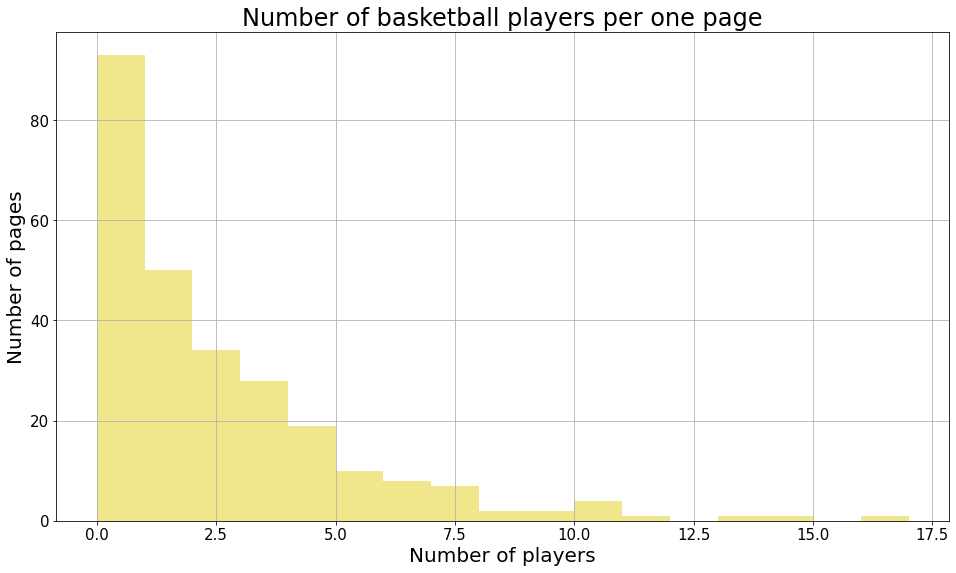

In [35]:
occurrences = find_occurrences(pages, basketball_players)

plt.figure(figsize=(16, 9))
plt.hist(occurrences, bins=max(occurrences), color=colors[1])
plt.title('Number of basketball players per one page', fontsize=24)
plt.ylabel('Number of pages', fontsize=20)
plt.xlabel('Number of players', fontsize=20)
plt.grid()

From graph above we can see that a lot of pages have any mentions about basketball player. Why is that? It's possible that KG states about his memories in first person using 'me' and its forms. Of course, not all book is about basketball player, he mentions about his family, about issues connected with God, about journalists, which were not included as basketball players previously.

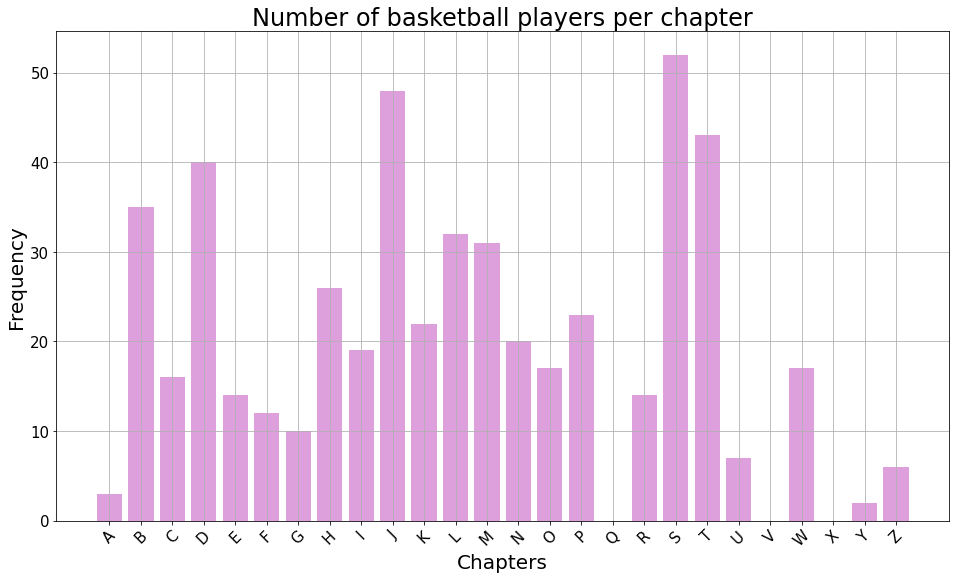

In [36]:
occurrences = find_occurrences(chapters, basketball_players)

plt.figure(figsize=(16, 9))
plt.title('Number of basketball players per chapter', fontsize=24)
plt.xlabel('Chapters', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.bar([chr(j) for j in range(65, 91)], occurrences, color=colors[2])
plt.xticks(rotation=45)
plt.grid()

Number of basketball player mentions looks definietely better if we consider chapters. In chapter 'S' there is the highest number of basketball player. Similarly for 'J' chapter. In chapter 'S' he mentions about his teammate from Minnesota Timberwolves, who died in a car accident. He uses his surname realy often in this chapter (Malik Sealy). Also, in some chapters there is only text about his belief (e.g. Q chapter), when KG thinks about his beliefs and faith in God.

In [37]:
biography_words = ['I', 'me', 'my', 'mine', 'myself', 'Kevin Garnett', 'Big Ticket', 'KG']

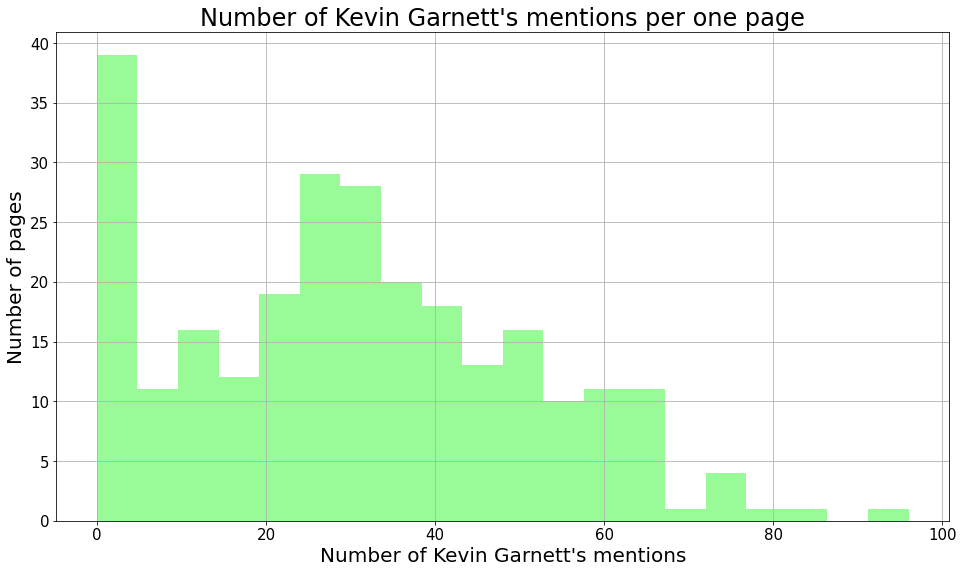

In [38]:
occurrences = find_occurrences(pages, biography_words)

plt.figure(figsize=(16, 9))
plt.hist(occurrences, bins=20, color=colors[4])
plt.title('Number of Kevin Garnett\'s mentions per one page', fontsize=24)
plt.ylabel('Number of pages', fontsize=20)
plt.xlabel('Number of Kevin Garnett\'s mentions', fontsize=20)
plt.grid()

If we consider number of typical for autobiography mentions, this distribution for every page looks definietely better. Kevin Garnett often uses in his book words connected to "me", which we can see from the graph above. Moreover, in one page he mentions about himself almost 100 times.

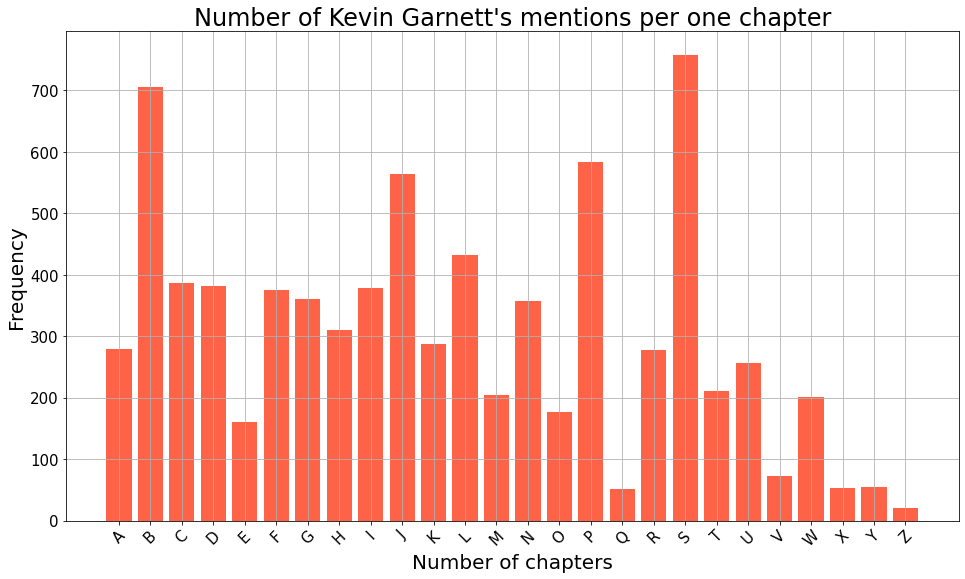

In [39]:
occurrences = find_occurrences(chapters, biography_words)

plt.figure(figsize=(16, 9))
plt.title('Number of Kevin Garnett\'s mentions per one chapter', fontsize=24)
plt.xlabel('Number of chapters', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.bar([chr(j) for j in range(65, 91)], occurrences, color=colors[0])
plt.xticks(rotation=45)
plt.grid()

If we consider number of typical for autobiography mentions, this distribution for every chapter is completely different. In every chapter he states about himself multiple times (even in chapter Q, which previously was free from basketball players)

## Graph of co-occurences (defined as mentions on the same page)

In [40]:
def find_basketball_players(text, basketball_players):
    found = []
    for player in basketball_players:
        if player in text:
            found.append(player)
            
    return None if len(found) <= 1 else found

In [41]:
def find_connections(places, limit):
    df = pd.DataFrame(places, columns={'Places'})
    df['Basketball Players'] = df.apply(lambda row: find_basketball_players(row.Places, basketball_players), axis=1)
    df = df[~df['Basketball Players'].isnull()]
    
    edges = []
    co_occurrences = list(df['Basketball Players'])
    for co_occurrence in co_occurrences:
        for coop in combinations(co_occurrence, 2):
            edges.append(tuple(sorted(coop)))

    edges_count = Counter(edges)
    mod_edges_count = dict()
    links = []
    for key, value in edges_count.items():
        if value > limit:
            links.append([key[0], key[1], value])
            mod_edges_count[(key[0], key[1])] = value
    
    return mod_edges_count, links

In [42]:
def create_graph(links, edges_count, title):
    G = nx.Graph()
    G.add_weighted_edges_from(links)
    
    weights = [G[u][v]['weight'] for u,v in G.edges]
    d = dict(G.degree)
    
    low, *_, high = sorted(d.values())
    norm = cm.colors.Normalize(vmin=low, vmax=high, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap='Wistia')
    
    plt.figure(figsize=(20, 10))
    pos=nx.shell_layout(G)
    nx.draw(G, pos, nodelist=d.keys(), node_size=[v * 100 for v in d.values()], node_color=[mapper.to_rgba(i) for i in d.values()])
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edges_count)
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_color='darkgreen')
    
    plt.title(title, fontsize=20)
    
    return G

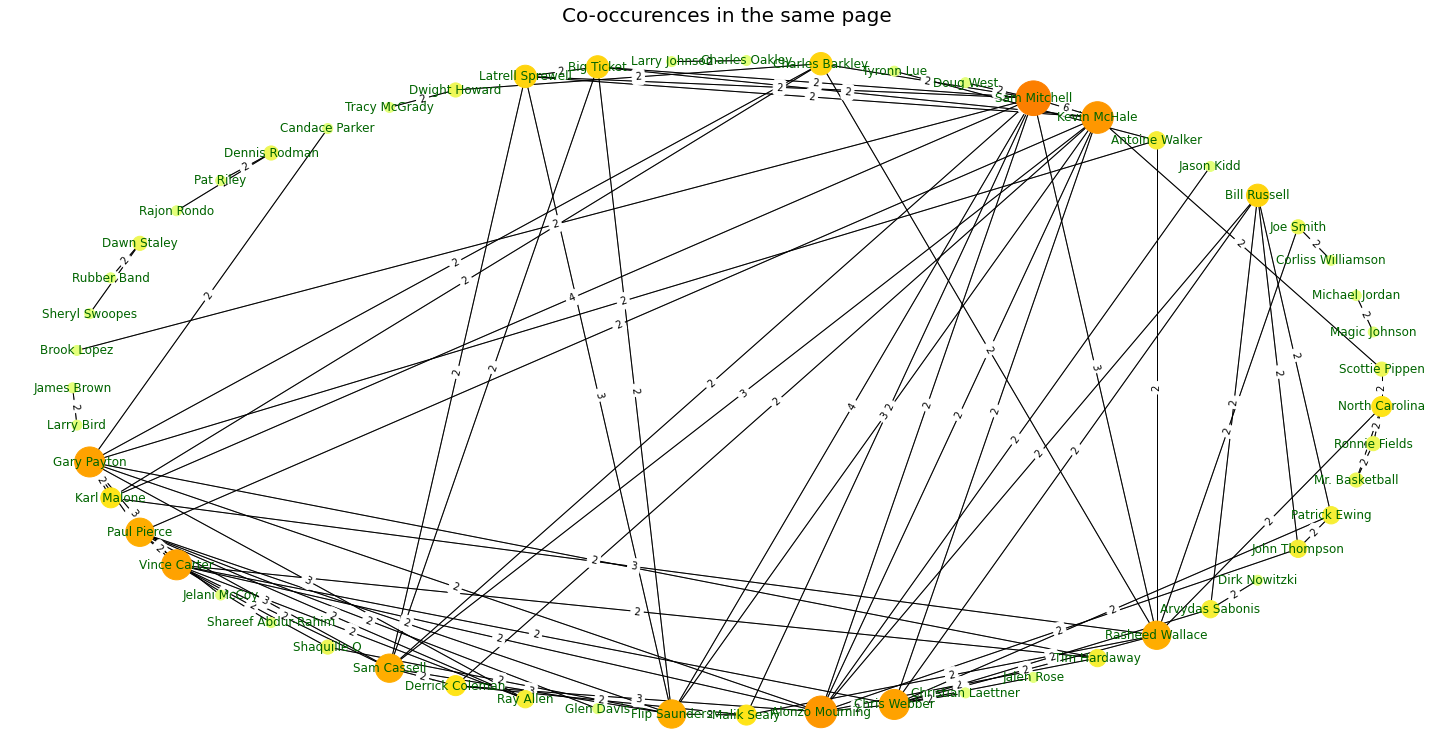

In [43]:
edges, links = find_connections(pages, 1)
create_graph(links, edges, 'Co-occurences in the same page')

## Graph of co-occurences (defined as mentions on the same chapter)

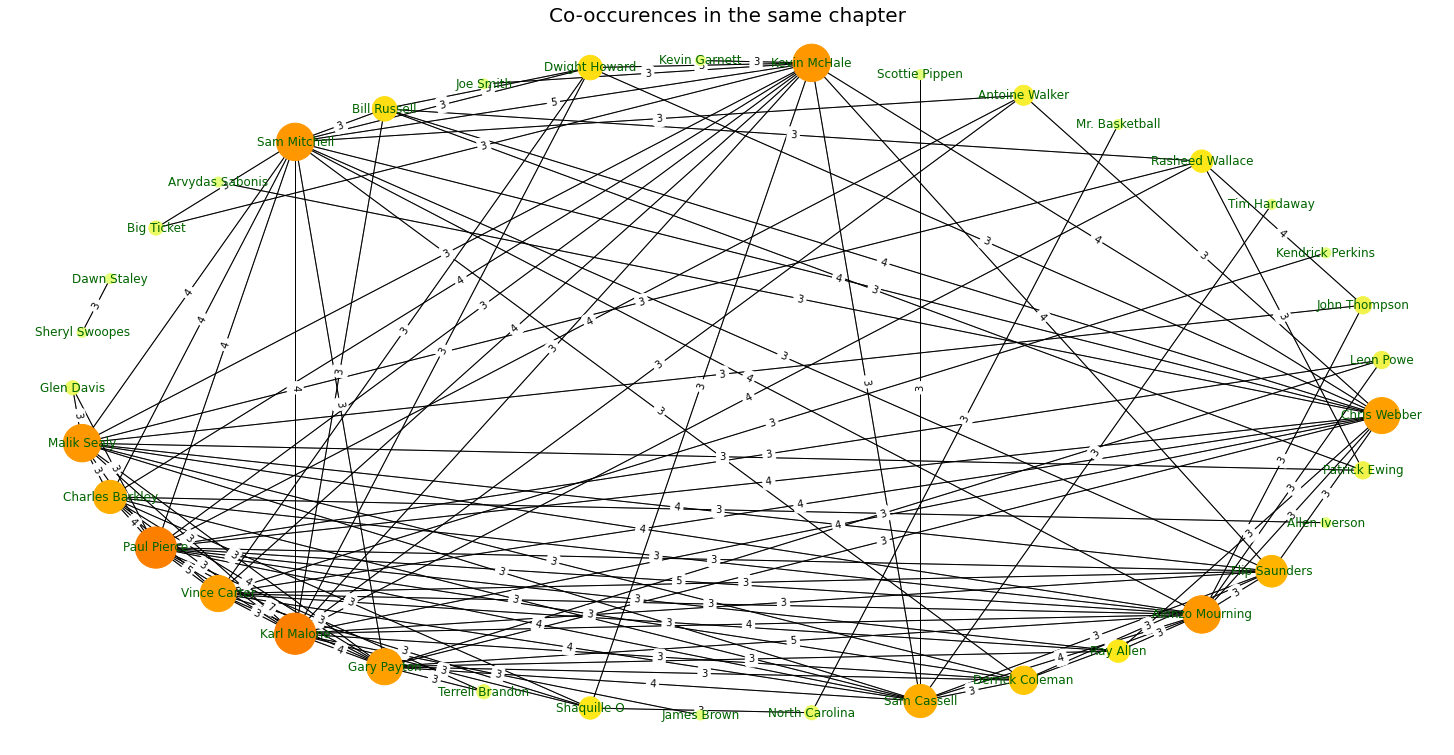

In [44]:
edges, links = find_connections(chapters, 2)
create_graph(links, edges, 'Co-occurences in the same chapter')

## Sentiment analysis of every chapter

In [45]:
def sentiment(text):
    sentence_sentiment = analyser.polarity_scores(text)
    
    return sentence_sentiment['compound']

In [46]:
def create_dataframe_with_sentiment(data):
    df = pd.DataFrame({'Chapter': [],
                       'Sentence index': [],
                       'Sentence': []})

    for i, chapter in enumerate(data):
        a_list = nltk.tokenize.sent_tokenize(chapter)
        df = df.append(pd.DataFrame({'Chapter': [i+1]*len(a_list), 'Sentence index': range(1, len(a_list)+1), 'Sentence': a_list}), ignore_index=True)

    df['Chapter'] = df['Chapter'].astype(int)
    df['Sentence index'] = df['Sentence index'].astype(int)

    df['Sentiment'] = df.apply(lambda row: sentiment(row.Sentence), axis=1)
    df['Words'] = df.apply(lambda row: finding_words(row.Sentence), axis=1)
    
    return df

In [47]:
df = create_dataframe_with_sentiment(chapters)

In [48]:
sentiments = df.groupby('Chapter').mean()['Sentiment']

In [49]:
df

,Chapter,Sentence index,Sentence,Sentiment,Words
0,1,1,"“Anything Is Possible!” It was 2008, and after...",0.7840,"[anything, possible, 2008, thirteen, season, f..."
1,1,2,"When the horn went off and the game was over, ...",0.0000,"[horn, game, time, freeze]"
2,1,3,My mind froze.,0.0000,"[mind, freeze]"
3,1,4,I had halfway been expecting a buzzer-beater; ...,0.0000,"[halfway, expect, buzzer-beater, blowout]"
4,1,5,We beat down the Lakers by thirty-nine points.,0.0000,"[beat, lakers, thirty-nine, point]"
...,...,...,...,...,...
8220,26,29,We need to take a stance and protect and promo...,0.8720,"[need, take, stance, protect, promote, folk, d..."
8221,26,30,We need to stay on the case and raise everyone...,0.2263,"[need, stay, case, raise, everyone, especially..."
8222,26,31,We need to feed these folk.,0.0000,"[need, fee, folk]"
8223,26,32,We need to supply them with food that nourishe...,0.1779,"[need, supply, food, nourish, mind, body, spirit]"


In [50]:
df[df['Sentiment'] < 0]

,Chapter,Sentence index,Sentence,Sentiment,Words
25,1,26,In the middle of the mad scramble I see Kobean.,-0.4939,"[middle, mad, scramble, see, kobean]"
31,1,32,I’ll see yo bitch ass next year.” I have to ge...,-0.8074,"[see, bitch, ass, next, year, get, blow, say, ..."
33,1,34,"“Love you, my brotha.” “Love you too, dawg.” T...",-0.4005,"[love, brotha, love, dawg, give, one, gorilla,..."
39,1,40,Attention deficit disorder and attention defic...,-0.8689,"[attention, deficit, disorder, attention, defi..."
41,1,42,"I also have dyslexia, meaning I see shit backw...",-0.5574,"[also, dyslexia, mean, see, shit, backwards]"
...,...,...,...,...,...
8200,26,9,But I did it with zero fucks.,-0.6310,"[zero, fuck]"
8201,26,10,Zero fucks if you start judging.,-0.4767,"[zero, fuck, start, judge]"
8204,26,13,Zero Tolerance For hate.,-0.3612,"[zero, tolerance, hate]"
8205,26,14,For racism.,-0.6249,[racism]


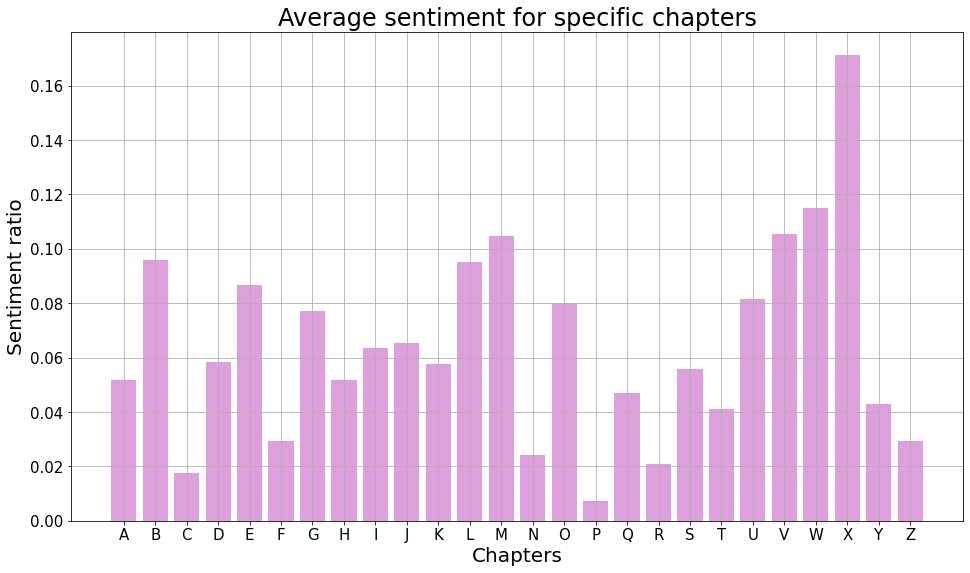

In [51]:
plt.figure(figsize=(16, 9))
plt.bar([chr(j) for j in range(65, 91)], sentiments, color=colors[2])
plt.title('Average sentiment for specific chapters', fontsize=24)
plt.xlabel('Chapters', fontsize=20)
plt.ylabel('Sentiment ratio', fontsize=20)
plt.grid()

From the graph above we can see that overall score of sentiment analysis is positive. Mean of positivenes of every sentences inside every chapter is always higer than 0. It makes this book mainly positive. It can be caused due to some memories, in which Kevin Garnet talks in a pleasant way

In [52]:
negative = len(df[df['Sentiment'] < -0.05])
positive = len(df[df['Sentiment'] > 0.05])
neutral = len(df) - positive - negative

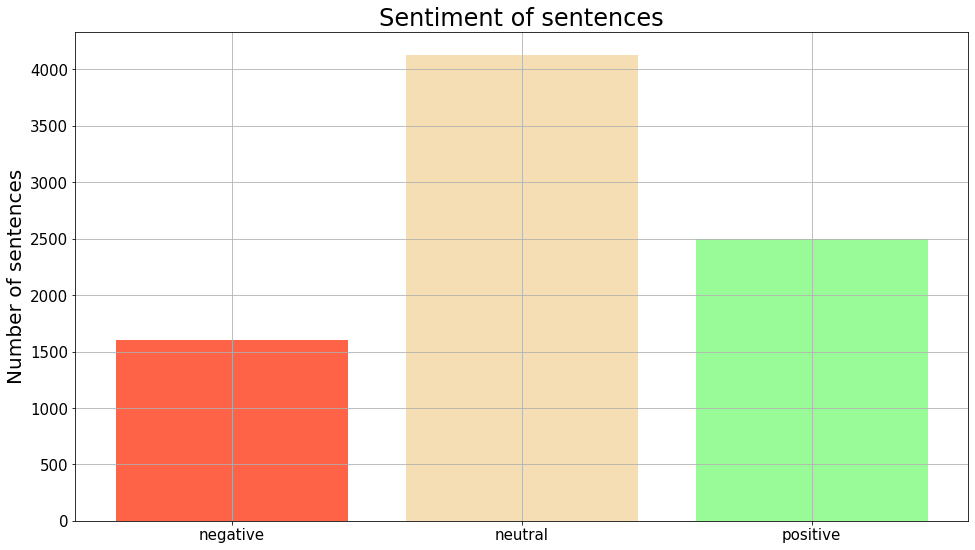

In [53]:
plt.figure(figsize=(16, 9))
plt.bar(['negative', 'neutral', 'positive'], [negative, neutral, positive], color=['tomato', 'wheat', 'palegreen'])
plt.ylabel('Number of sentences', fontsize=20)
plt.title('Sentiment of sentences', fontsize=24)
plt.grid()

Almost more than 4000 sentences are classified as neutral ones, 2500 sentences are positivie for readers and 1500 are negative. It makes this book basically more positive than negative. Of course, there is a lot of neutral sentences. However, number of positive sentences is significantly higher than number of negative sentences.

In [54]:
negative_words = list(df[df['Sentiment'] < -0.05]['Words'])
positive_words = list(df[df['Sentiment'] > 0.05]['Words'])

negative_words = [word for negative_word in negative_words for word in negative_word] 
positive_words = [word for positive_word in positive_words for word in positive_word]

In [55]:
neg = []
for negative_word in negative_words:
    if negative_word not in common_words:
        neg.append(negative_word)
        
negative_words = neg[:]

pos = []
for positive_word in positive_words:
    if positive_word not in common_words:
        pos.append(positive_word)
        
positive_words = pos[:]

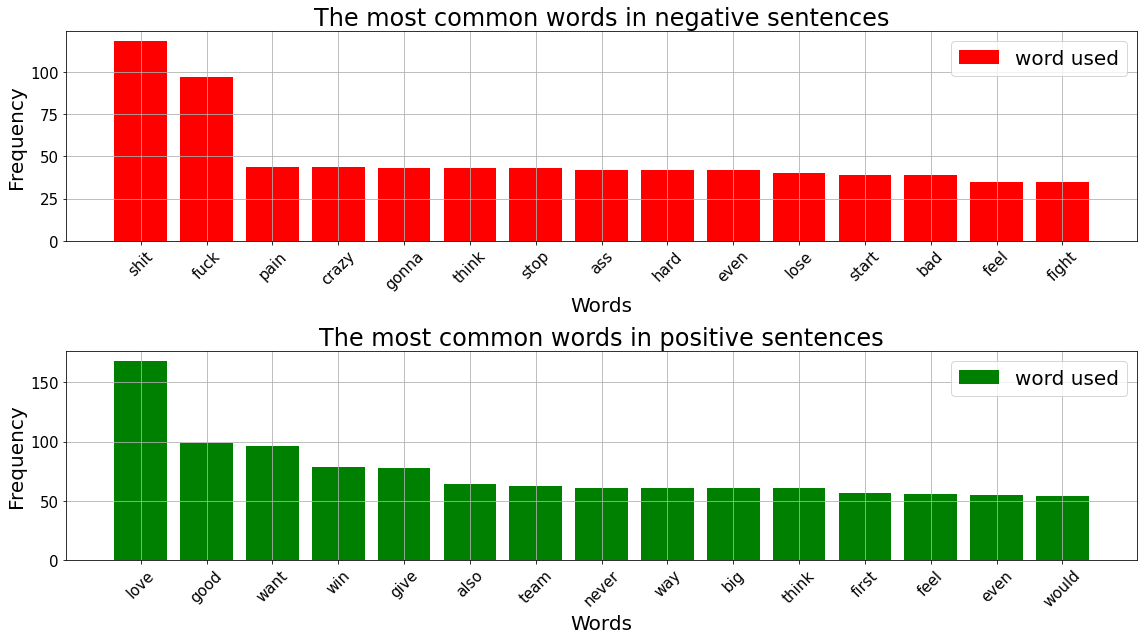

In [56]:
plt.figure(figsize=(16, 9))
plt.subplot(2, 1, 1)
words, occurrences = find_the_most_common_words(neg, limit=15)

plt.title('The most common words in negative sentences', fontsize=24)
plt.xlabel('Words', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.bar(words, occurrences, color='red')
plt.legend(['word used'], prop={'size': 20})
plt.xticks(rotation=45)
plt.grid()

plt.subplot(2, 1, 2)
words, occurrences = find_the_most_common_words(positive_words, limit=15)
plt.title('The most common words in positive sentences', fontsize=24)
plt.xlabel('Words', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.bar(words, occurrences, color='green')
plt.legend(['word used'], prop={'size': 20})
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()

The most common words from negative sentences actually show real state of this sentence, some bad words, pain connected to physical and mental sphere, some words like lose, which should refer to all games, which he lost. In the other hand, there are a lot of positive words like love, good, win, team, which being alone (not only in a sentence) have a positive meaning.

## Wordcloud with custom image as a background

In [57]:
cleaned_words = finding_words(all_text)

In [58]:
def generate_wordcloud(data, mask=None):
    data=Counter(data)
    cloud = WordCloud(scale=3,
                      max_words=150,
                      colormap='Oranges',
                      mask=mask,
                      background_color='black',
                      contour_color='white',
                      contour_width=1).generate_from_frequencies(data)
    plt.figure(figsize=(16,16))
    plt.imshow(cloud)
    plt.axis('off')
    plt.show()

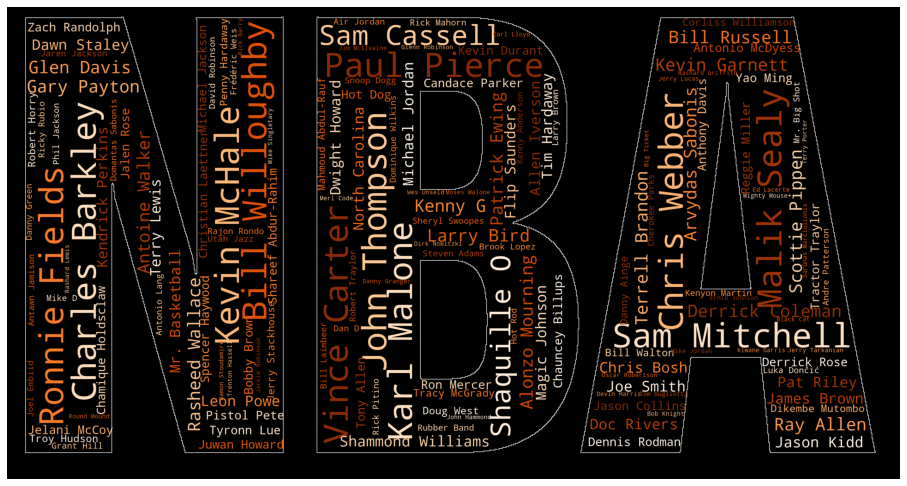

In [59]:
mask = np.array(Image.open('nba.png'))
generate_wordcloud(basketball_players, mask=mask)

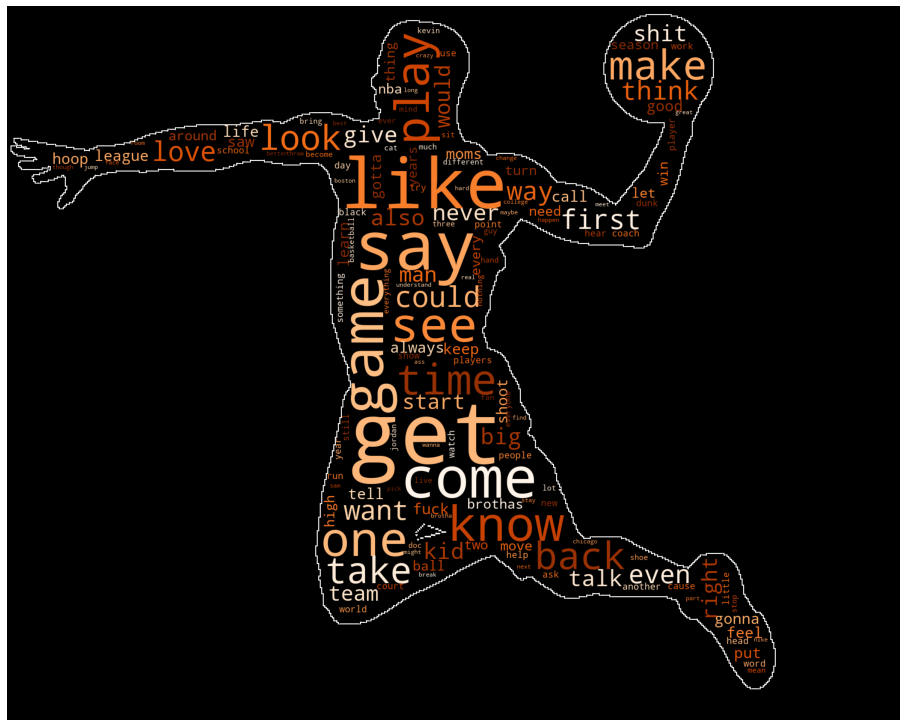

In [60]:
mask = np.array(Image.open('basket1.png'))
generate_wordcloud(cleaned_words, mask=mask)

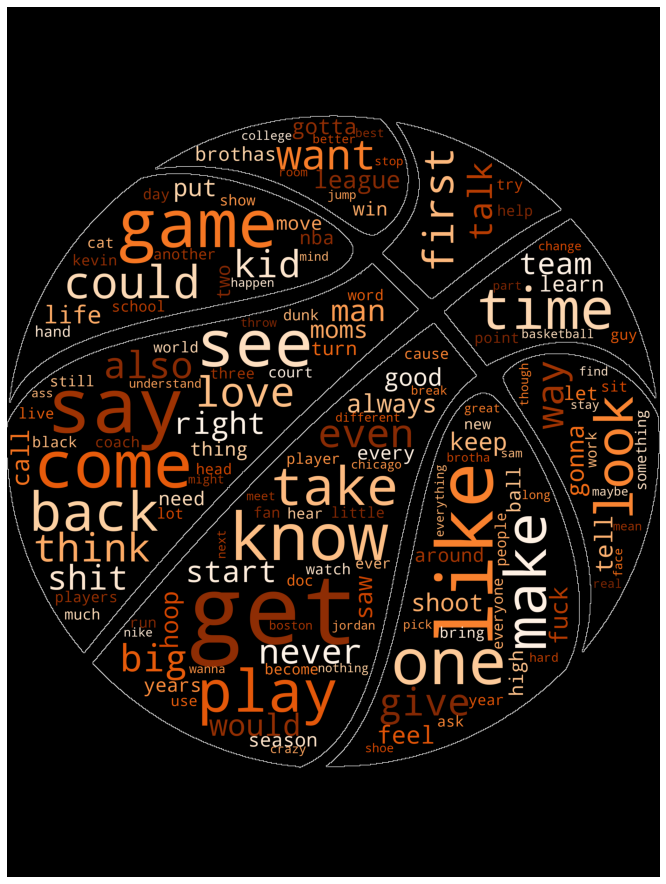

In [61]:
mask = np.array(Image.open('basket2.png'))
generate_wordcloud(cleaned_words, mask=mask)

## Summary

After some difficulties in converting the epub file to pdf, we were able to take a look at this biography "KG: A to Z: An Uncensored Encyclopedia of Life, Basketball, and Everything in Between", which was written by Kevin Garnett. We 've analyzed 26 chapters, 261 pages, and 8218 sentences. Every chapter in this book was marked as a letter from the alphabet, so the name of the encyclopedia in the title is a proper one to describe this book. Basically, the book is written using rather standard - informal words using a lot of basketball words and of course -  a lot of bad words, which express a lot of good and bad emotions. However, the overall score of sentiment analysis of this book is positive due to a lot of memories and good moments, which are discussed in positive aspects. 